> 在本例中，使用公式选股并进行回测

In [1]:
%matplotlib inline

import os
import datetime as dt
import pandas as pd
import numpy as np
from PyFin.api import *
from alphamind.api import *
from matplotlib import pyplot as plt

## 1. 参数设置
----------------

* 调仓频率：每周
* 股票池  ：hs300
* 起始日  ：2020-01-01
* 结束日  ：2020-02-21
* 业绩基准：沪深300

In [2]:
freq = "1w"
universe = Universe('hs300')
engine = SqlEngine(os.environ['DB_URI'])
start_date = '2020-01-02'
end_date = '2020-02-21'
benchmark_code = 300
rebalance_dates = makeSchedule(start_date, end_date, freq, 'china.sse', BizDayConventions.Preceding)

## 2. 选股公式
-----------------------

* 在每个调仓日获取每个行业按照`ETOP`因子排序，最高的3支股票。行业分类使用申万1级

In [3]:
formula = CSTopN(LAST('EMA5D'), 3)

## 3. 计算过程
----------------

* 获取因子值以及行业信息

In [4]:
%%time
factors = engine.fetch_factor_range(universe, {'alpha': formula}, dates=rebalance_dates)
industries = engine.fetch_industry_range(universe, dates=rebalance_dates)

Wall time: 6.07 s


* 因子选股并且进行获取相关股票每日收益

In [5]:
%%time
chosen_stks = factors[factors.alpha == 1.]
codes = chosen_stks.code.unique()
stk_returns = engine.fetch_dx_return_range(universe, start_date, end_date)

Wall time: 10 s


* 计算每日调仓结果以及收益

In [6]:
%%time

ret_dates = np.unique(stk_returns.trade_date)
rebalance_dates = chosen_stks.trade_date.unique()

rtn_groups = stk_returns.groupby('trade_date')
industry_groups = industries.groupby('trade_date')
stks_groups = chosen_stks.groupby('trade_date')

portfolio_rtns = []
portfolios = pd.DataFrame(columns=['code', 'weight', 'industry'])

for ref_date, g in rtn_groups:
    ref_date = ref_date.to_datetime64()
    nearest_date = rebalance_dates[rebalance_dates <= ref_date][-1]
    this_codes = stks_groups.get_group(nearest_date)['code'].tolist()
    
    next_day_rtn = g.loc[g.code.isin(this_codes), 'dx'].values
    portfolio_nd_rtn = np.mean(next_day_rtn)
    portfolio_rtns.append(portfolio_nd_rtn)
    if ref_date in rebalance_dates:
        this_industry = industry_groups.get_group(nearest_date).set_index('code')
        this_df = pd.DataFrame(data={'code': this_codes,
                                     'weight': np.ones(len(this_codes)) * 1. / len(this_codes),
                                     'industry': this_industry.loc[this_codes, 'industry'].values})
        this_df.index =[ref_date] * len(this_codes)
        portfolios = portfolios.append(this_df)

portfolio_rtns = pd.DataFrame({'ret': portfolio_rtns}, index=ret_dates)

Wall time: 74 ms


## 4. 表现展示
-------------------

### 4.1 日收益与回撤

In [7]:
from PyFin.Math.Accumulators import MovingDrawdown

In [8]:
%%time
mv = MovingDrawdown(window=1000, x='ret')
dds = []

for r in portfolio_rtns['ret'].values:
    mv.push({'ret': r})
    dds.append(mv.value)

portfolio_rtns['dd.'] = dds

Wall time: 2 ms


* 累积收益曲线 + 回撤曲线

(-0.6, 0.3)

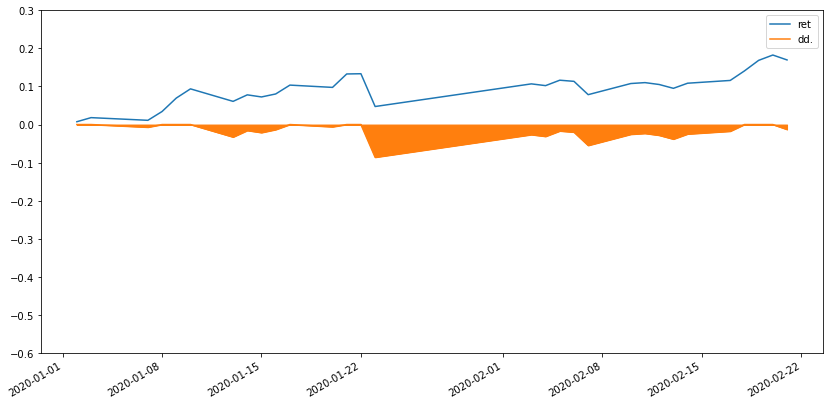

In [9]:
portfolio_rtns['ret'].cumsum().plot(figsize=(14, 7))
portfolio_rtns['dd.'].plot(kind='area')
plt.legend(['ret', 'dd.'])
plt.ylim([-0.6, 0.3])

* 最大回撤、年化收益

In [10]:
print("最大回撤： {0:.2f}%".format(-np.min(portfolio_rtns['dd.']) * 100.))
print("年化收益： {0:.2f}%".format(250 * np.mean(portfolio_rtns['ret']) * 100.))

最大回撤： 8.61%
年化收益： 136.82%


### 4.2 超额收益以及alpha

In [11]:
%%time
benchmark = engine.fetch_dx_return_index_range(benchmark_code, start_date, end_date)[['trade_date', 'dx']].set_index('trade_date')['dx']

Wall time: 218 ms


In [12]:
excess_ret = portfolio_rtns['ret'] - benchmark
print("年化超额收益： {0:.2f}%".format(250 * np.mean(excess_ret) * 100.))

年化超额收益： 140.59%


In [13]:
%%time

p_rets = portfolio_rtns['ret'].values
b_rets = benchmark.values
x = np.concatenate([np.ones((len(b_rets),1)), b_rets.reshape((-1, 1))], axis=1)
alpha, beta = np.linalg.solve(x.T @ x, x.T @ p_rets)
print("年化alpha： {0:.2f}%".format(250 * alpha * 100.))
print("beta： {0:.2f}".format(beta))

年化alpha： 140.49%
beta： 0.97
Wall time: 2 ms


### 4.3 月度收益

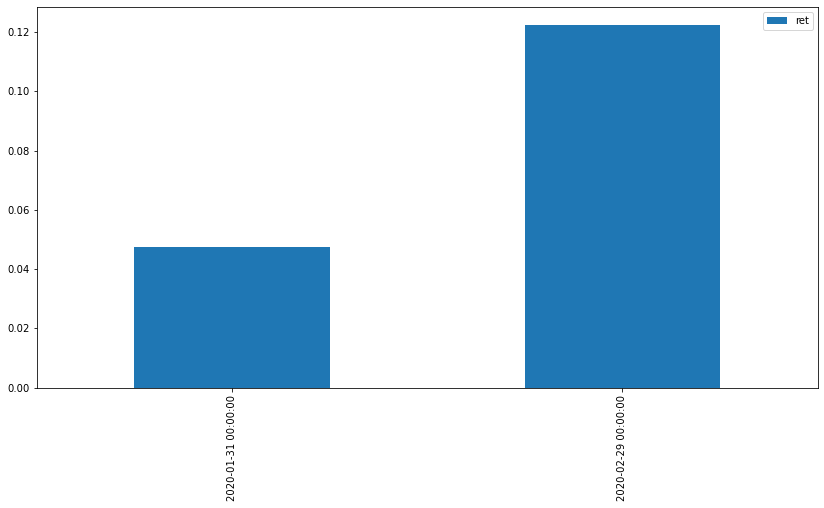

In [14]:
portfolio_rtns['ret'].resample('M').sum().plot(figsize=(14, 7), kind='bar')
plt.legend(['ret'])

### 4.4 行业分布

In [15]:
portfolios.reset_index().groupby(['index', 'industry']).count()

code  weight
index      industry              
2020-01-02 医药生物         1       1
           电子           1       1
           食品饮料         1       1
2020-01-09 医药生物         1       1
           电子           1       1
           食品饮料         1       1
2020-01-16 医药生物         1       1
           电子           1       1
           食品饮料         1       1
2020-01-23 医药生物         1       1
           电子           1       1
           食品饮料         1       1
2020-02-06 医药生物         1       1
           电子           1       1
           食品饮料         1       1
2020-02-13 医药生物         1       1
           电子           1       1
           食品饮料         1       1
2020-02-20 医药生物         1       1
           电子           1       1
           食品饮料         1       1
2020-02-21 医药生物         1       1
           电子           1       1
           食品饮料         1       1

### 4.5 换手率

* 月换手直方图

In [16]:
%%time

p_groups = portfolios.groupby(level=0)

previous_date = None
previous_pos = None

turn_over = []

for ref_date, g in p_groups:
    g = g.set_index('code')
    if previous_date:
        diff_pos = g['weight'].subtract(previous_pos, fill_value=0)
        turn_over.append(diff_pos.abs().sum())
    previous_date = ref_date
    previous_pos = g['weight']

turn_over = pd.Series(turn_over, index=portfolios.index.unique()[1:])

Wall time: 14 ms


<AxesSubplot:>

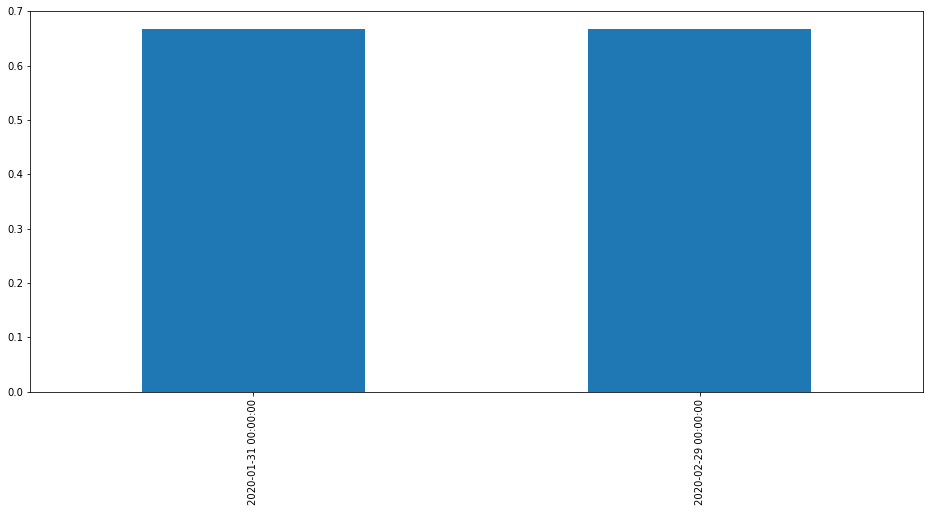

In [17]:
turn_over.resample('M').sum().plot(kind='bar', figsize=(16, 7))